In [1]:
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

--2020-03-01 14:48:09--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy’

mnist_test_seq.npy  100%[===================>] 781.25M  82.2MB/s    in 9.7s    

2020-03-01 14:48:18 (80.4 MB/s) - ‘mnist_test_seq.npy’ saved [819200096/819200096]



In [2]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, MaxPooling2D, MaxPooling3D, Dropout, BatchNormalization, Flatten, Conv2D, Conv3D, AveragePooling3D, LSTM, Reshape
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
path = "./"
data = np.load(path + 'mnist_test_seq.npy')
print(data.shape)
# Define image dimensions and frames to be used for LSTM memory
sequence_length = 15
image_height = data.shape[2]
image_width = data.shape[3]

(20, 10000, 64, 64)


In [0]:
# swap frames and observations so [obs, frames, height, width, channels]
data = data.swapaxes(0, 1)

In [5]:
print(data.shape)

(10000, 20, 64, 64)


In [6]:
# only select first 100 observations to reduce memory- and compute requirements
sub = data[:900, :, :, :]
print(sub.shape)

(900, 20, 64, 64)


In [7]:
# add channel dimension (grayscale)
sub = np.expand_dims(sub, 4)
print(sub.shape)

(900, 20, 64, 64, 1)


In [8]:
# normalize to 0, 1
#sub = sub / 255
sub[sub < 128] = 0
sub[sub>= 128] = 1
# Define network
print(sub.shape)

(900, 20, 64, 64, 1)


In [9]:
seq = Sequential()

seq.add(ConvLSTM2D(filters=64, kernel_size=(7, 7),input_shape=(None, image_height, image_width, 1), padding='same', dropout=0.4, recurrent_dropout=0.2, kernel_initializer='glorot_uniform', unit_forget_bias=True, activation='tanh', recurrent_activation='hard_sigmoid', go_backwards=True, return_sequences=True))
seq.add(BatchNormalization())
seq.add(ConvLSTM2D(filters=32, kernel_size=(7, 7),input_shape=(None, image_height, image_width, 1), padding='same', dropout=0.4, recurrent_dropout=0.2, kernel_initializer='glorot_uniform', unit_forget_bias=True, activation='tanh', recurrent_activation='hard_sigmoid', go_backwards=True, return_sequences=True))
seq.add(ConvLSTM2D(filters=16, kernel_size=(7, 7),input_shape=(None, image_height, image_width, 1), padding='same', dropout=0.4, recurrent_dropout=0.2, kernel_initializer='glorot_uniform', unit_forget_bias=True, activation='tanh', recurrent_activation='hard_sigmoid', go_backwards=True, return_sequences=True))
seq.add(BatchNormalization())
seq.add(ConvLSTM2D(filters=8, kernel_size=(7, 7),input_shape=(None, image_height, image_width, 1), padding='same', dropout=0.3, recurrent_dropout=0.2, kernel_initializer='glorot_uniform', unit_forget_bias=True, activation='tanh', recurrent_activation='hard_sigmoid', go_backwards=True, return_sequences=True))
seq.add(BatchNormalization())
seq.add(Conv3D(filters=1, kernel_size=(3,3,3), activation='sigmoid', padding='same', data_format='channels_last'))

#seq.compile(loss='binary_crossentropy', optimizer='RMSprop',metrics = ['acc'])
#keras.optimizers.RMSprop(lr=0.01)
seq.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['acc'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Add helper function for shifting input and output, so previous frame (X_t-1) is used as input to predict next frame (y_t)
def shift_data(data, n_frames=15):
  X = data[:, 0:n_frames, :, :,:]
  y = data[:, 1:(n_frames+1), :, :]
  return X, y

In [0]:
# prepare X, y
X, y = shift_data(sub, sequence_length)

In [12]:
print("X is:", X.shape)
print("y is:", y.shape)

X is: (900, 15, 64, 64, 1)
y is: (900, 15, 64, 64, 1)


In [13]:
# fit the model
history = seq.fit(X, y, batch_size=6, epochs=40, validation_split=0.1)




Train on 810 samples, validate on 90 samples
Epoch 1/40





810/810 [==============================] - 166s 205ms/step - loss: 0.3359 - acc: 0.8982 - val_loss: 0.1661 - val_acc: 0.9487
Epoch 2/40
810/810 [==============================] - 148s 183ms/step - loss: 0.0912 - acc: 0.9638 - val_loss: 0.0794 - val_acc: 0.9669
Epoch 3/40
810/810 [==============================] - 148s 183ms/step - loss: 0.0545 - acc: 0.9782 - val_loss: 0.0457 - val_acc: 0.9825
Epoch 4/40
810/810 [==============================] - 148s 183ms/step - loss: 0.0401 - acc: 0.9841 - val_loss: 0.0415 - val_acc: 0.9846
Epoch 5/40
810/810 [==============================] - 148s 183ms/step - loss: 0.0329 - acc: 0.9869 - val_loss: 0.0247 - val_acc: 0.9906
Epoch 6/40
810/810 [==============================] - 148s 183ms/step - loss: 0.0286 - acc: 0.9885 - val_loss: 0.7249 - val_acc: 0.8841
Epoch 7/40
810/810 [==============================] - 148s 183ms/step - loss: 0.0254 - acc: 0.9898 - val_loss: 0.0176 - val_acc: 0.

In [18]:
# select a random observation
# track and test set have to be the same observation
test_set = np.expand_dims(X[90, ::, ::, ::, ::], 0)
track = X[90, :10, ::, ::, ::]
print("test set:", test_set.shape)
print("track:", track.shape)

test set: (1, 15, 64, 64, 1)
track: (10, 64, 64, 1)


In [19]:
for j in range(15):
    ##new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)

print("new_pos:", new_pos.shape)
print("new:", new.shape)
print("track:", track.shape)

new_pos: (1, 24, 64, 64, 1)
new: (1, 64, 64, 1)
track: (25, 64, 64, 1)


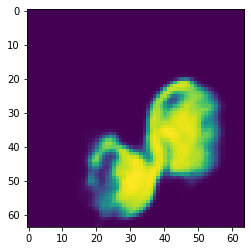

In [21]:
plt.imshow(track[12, ::, ::, 0]) #Test

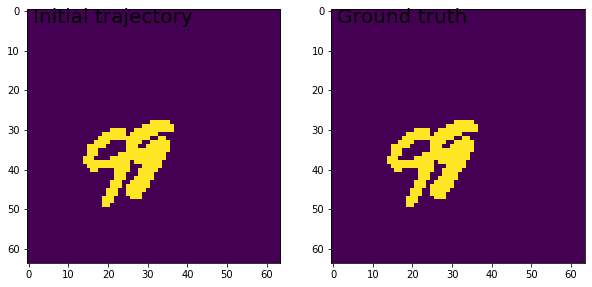

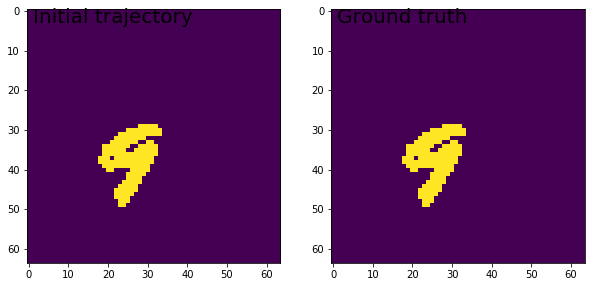

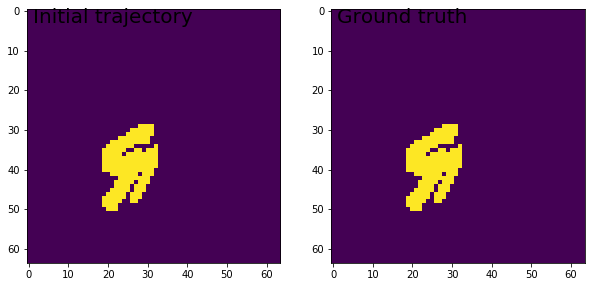

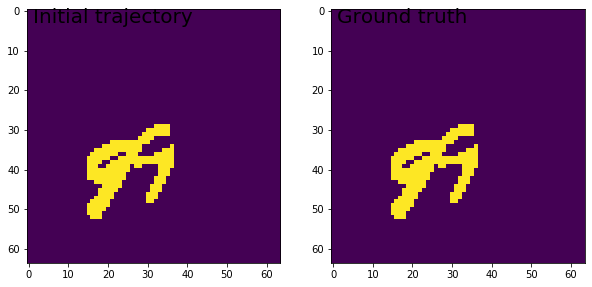

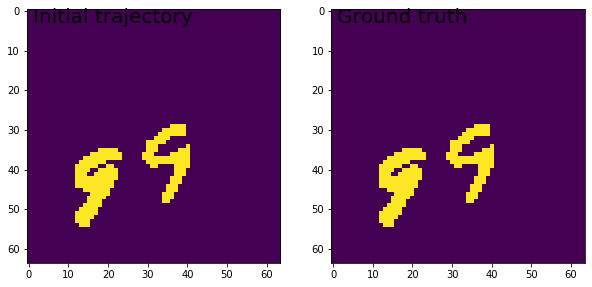

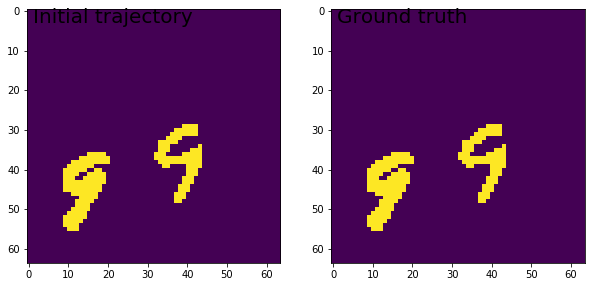

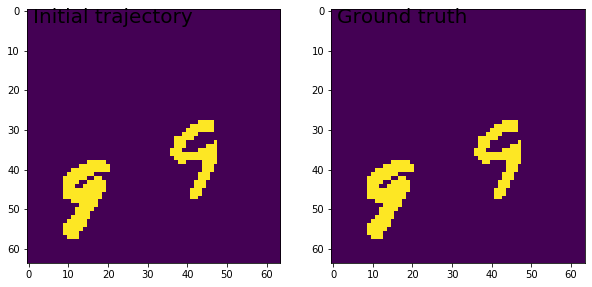

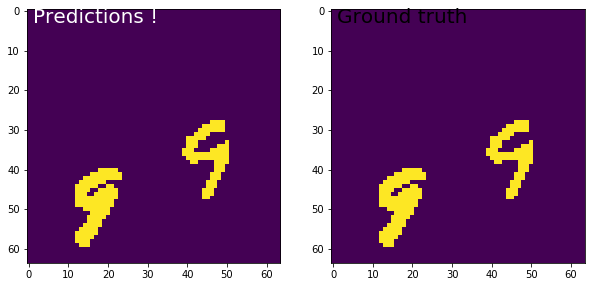

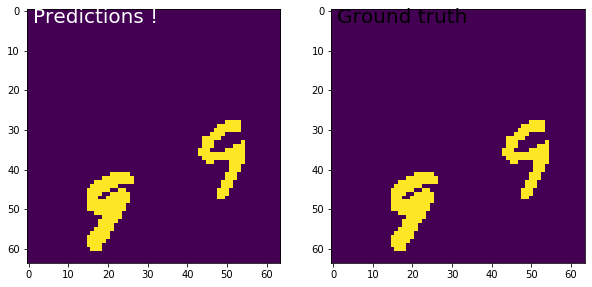

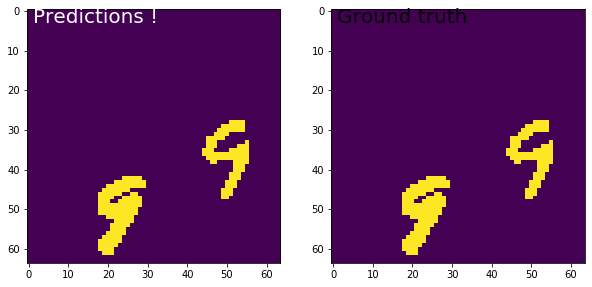

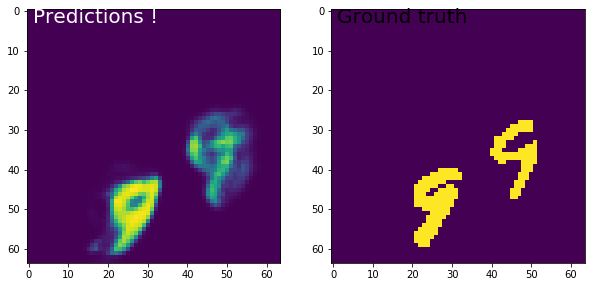

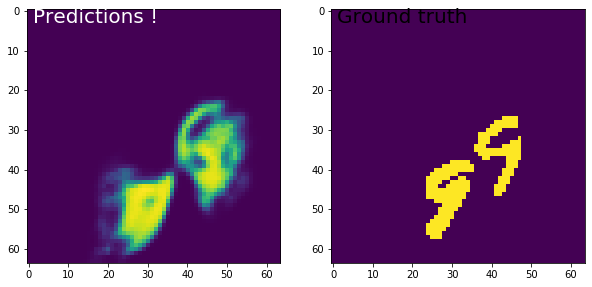

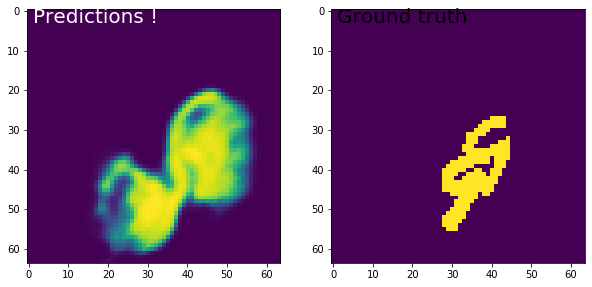

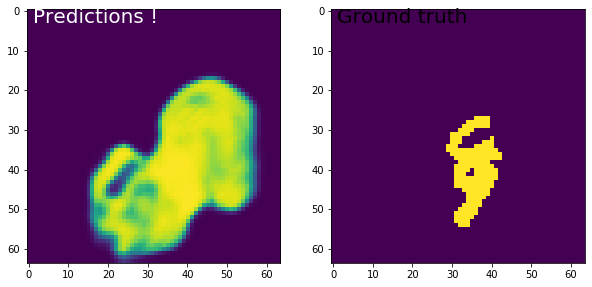

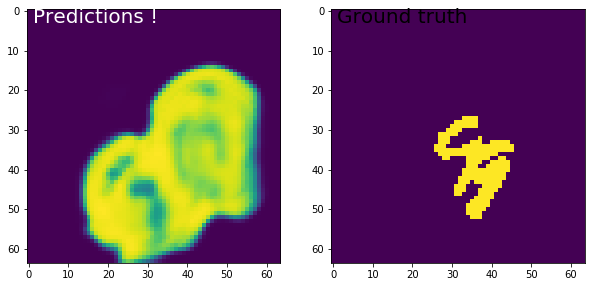

In [22]:
# And then compare the predictions
# to the ground truth
track2 = test_set
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[0,i, ::, ::, 0]
    
    plt.imshow(toplot)
    plt.savefig('%i_animate.png' % (i + 1))
